In [1]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
__author__ = 'Author'
__email__ = 'Email'

# Share Plots - Radar Charts
This notebook serves as a helpful guide for generating visually appealing figures using popular Python plotting libraries. Whether you're a researcher, data scientist, or student, well-crafted bar charts are essential for presenting data in a clear and impactful manner. In this notebook, you will find easy-to-follow code examples and step-by-step instructions to create various types of charts, including:
1. Radar chart with labels

In [2]:
# built-in
import os
from math import pi
# public
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 26})
colors = [plt.cm.Paired(i) for i in range(20)]
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from matplotlib.patches import RegularPolygon
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
# private
from src import utils

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

---
## 1. Radar chart with labels
+ https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

In [3]:
# helper
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [4]:
# init
data_path = os.path.join('res', 'radar', '0.pkl')
data_dict = utils.load_pickle(data_path)
text_xs = data_dict['text_xs']
image_xs = data_dict['image_xs']

In [5]:
labels = ['MES (Easy)', 'MES (Hard)', 'LogicQA', 'MMLU', 'TU', 'MR', 'SM']
N = len(labels)
theta = radar_factory(N, frame='polygon')
# Create the angles for the axis
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the loop

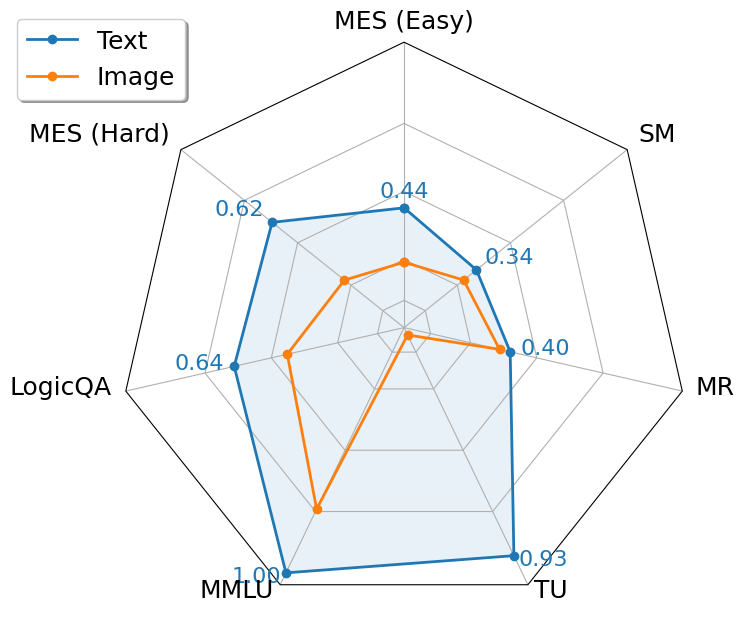

In [6]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='radar'))
# text
ax.plot(
    theta
    , text_xs
    , linewidth=2
    , marker='o'
    , label='Text'
)
ax.fill(
    theta
    , text_xs
    , alpha=0.1
)
# Add value labels at each point
for i in range(len(text_xs)):
    if i < len(labels):  # To avoid plotting the label for the closing point
        angle = angles[i]
        if angle in (0, pi):
            ha = 'center'
        elif 0 < angle < pi:
            ha = 'right'
        else:
            ha = 'left'
        ax.text(
            angle
            , text_xs[i] + 0.04
            , f'{text_xs[i]:.2f}'
            , size=16
            , color='C0'
            , horizontalalignment=ha
        )
# img
ax.plot(
    theta
    , image_xs
    , linewidth=2
    , marker='o'
    , label='Image'
)
# Manually position the labels
for label, angle in zip(labels, angles[:-1]):
    if angle in (0, pi):
        v = 1.1
        ha = 'center'
    elif 0 < angle < pi:
        v = 1.1
        ha = 'right'
    else:
        v = 1.1
        ha = 'left'
    # Adjust the label position
    ax.text(angle
            , v
            , label
            , horizontalalignment=ha
            # , fontweight=540
            , size=18)
# labels
ax.set_varlabels([])
ax.set_rticks([0.25, 0.5, 0.75, 0.1])  # Define your scale
ax.set_yticklabels([])
# Show the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.04, 0.88), ncol=1, fancybox=True, shadow=True, fontsize=18)
plt.tight_layout()
plt.show()